In [8]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_groq langchain_community
%pip install -U tavily-python langchain_community


In [9]:
import os
from google.colab import userdata

os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic_Chat"
os.environ["GROQ_API_KEY"] = "GROQ_API_KEY"


tavily_api_key = userdata.get('TAVILY_API_KEY')


groq_api_key = userdata.get('GROQ_API_KEY')

In [10]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    api_key=groq_api_key
)
llm.invoke("hi I am Mr Huzaifa")

AIMessage(content="Hello Mr. Huzaifa, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 42, 'total_tokens': 72, 'completion_time': 0.143934309, 'prompt_time': 0.011705347, 'queue_time': 0.0003683130000000003, 'total_time': 0.155639656}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'stop', 'logprobs': None}, id='run-e81bb373-4f85-442d-b504-25be286ef9a9-0', usage_metadata={'input_tokens': 42, 'output_tokens': 30, 'total_tokens': 72})

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")
llm_with_tools=llm.bind_tools(tools)

In [12]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [13]:
from langchain_core.messages import trim_messages
from langgraph.graph import MessagesState

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [14]:
graph_builder = StateGraph(State)

In [15]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition, ToolNode


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")


memory = MemorySaver()
graph = graph_builder.compile(interrupt_before=["tools"],checkpointer=memory)



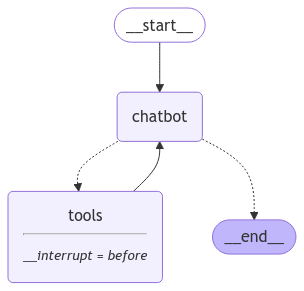

In [16]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:

def stream_graph_updates(user_input: str):
    events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
           event["messages"][-1].pretty_print()
config = {"configurable": {"thread_id": "1"}}
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about AI?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


User: hi i am Huzaifa
================================ Human Message =================================

hi i am Huzaifa
================================== Ai Message ==================================

It's nice to meet you, Huzaifa. Is there something I can help you with or would you like to chat?
User: what about you
================================ Human Message =================================

what about you
================================== Ai Message ==================================

I'm just a language model, so I don't have a personal identity like humans do, but I'm here to help answer your questions and provide information on a wide range of topics. How can I assist you today?
User: okay
================================ Human Message =================================

okay
================================== Ai Message ==================================

If you're ready to move forward, I can try to help with something specific or we can just chat. What's been on your min